# Analyzing Ithaca's Gorge Stewarding Program

##  Import and Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install hdbscan
# !pip install umap-learn

In [352]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
# nltk.download('punkt')
from collections import Counter
from nltk.corpus import stopwords
# nltk.download('stopwords')
import string
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import re
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from   sklearn.preprocessing import StandardScaler
import spacy
from   transformers import DistilBertTokenizerFast, DistilBertModel
import requests
import torch
from transformers import Trainer, TrainingArguments


In [4]:
np.random.seed(42)

In [5]:
gorges = pd.read_csv("/content/gorges.csv")
gorges = gorges.iloc[:, :-12]
gorges.loc[146, 'Date'] = "6/30/2022"
gorges.loc[215, 'Date'] = "5/28/2021"
gorges.loc[509, 'Date'] = "6/5/2019"
gorges.loc[529, 'Date'] = "6/19/2019"
gorges.loc[558, 'Date'] = "7/3/2019"
gorges.loc[589, 'Date'] = "7/17/2019"
gorges.loc[599, 'Date'] = "7/22/2019"
gorges.loc[620, 'Date'] = "7/31/2019"
gorges.loc[649, 'Date'] = "8/14/2019"
gorges.loc[669, 'Date'] = "8/28/2019"
gorges.loc[667, 'Date'] = "8/28/2019"

# convert date into a date object
gorges['Date'] = pd.to_datetime(gorges['Date'])

print(len(gorges))
gorges.head()


1107


,Date,Patrol Time,Steward name,High Temperature,Weather,Number of observed gorge users,total Number of people obseved violating a rule,Number of person interactions: Alternatives,Number of person interactions: Warnings,Number of person interactions: Directions,Total number of person interactions (Daily),Number of contacts to CUPD,Number of People above Ithaca Falls?,Description of Interactions,Description of notable events
0,2023-05-25,11AM-7PM,Brenner,61,"sunny, windy",168,0,0.0,0.0,1.0,1.0,0,0,Someone asked about north campus,saw some geese babies!
1,2023-05-26,11AM-7PM,Brenner,68,"sunny, clear",264,0,0.0,0.0,9.0,9.0,0,0,lots of commencement direction questions,numerous grad photos
2,2023-05-27,11AM-7PM,Brenner,77,sunny,251,2,0.0,2.0,5.0,7.0,0,0,few people suntanning on rocks in the water,someone asked me where the slope was lol
3,2023-05-28,11-7PM,Phillip,81,Sunny,184,5,0.0,5.0,9.0,14.0,0,0,"Lots of people looking for arboretum, three do...",I saw a cool butterfly
4,2023-05-29,11-7PM,Phillip,85,Sunny,102,0,0.0,0.0,6.0,0.0,0,0,"Big day for tourists, small day for violators",Found boathouse key on Bebee lake trail. Is no...


In [6]:
# extract out the observations column that aren't nan
interactions_df = gorges[gorges['Description of Interactions'].notna()]
interactions_df = interactions_df[interactions_df['Description of Interactions'] != '0']
interactions_df = interactions_df.iloc[:285, :]

# keep only non-na observations
observations_df = gorges[gorges['Description of notable events'].notna()]

#place all the interactions and observations into a dictionary (this is later uncased, but may be helpful)
log = {'interaction': [],'observation': []}

for i in range(len(interactions_df)):
    msg = {'index': i,
           'date': interactions_df.iloc[i, 0],
           "steward": interactions_df.iloc[i, 2],
           "msg": interactions_df.iloc[i, 13]}
    log['interaction'].append(msg)

for i in range(len(observations_df)):
    msg = {'index': i,
           'date': observations_df.iloc[i, 0],
           "steward": observations_df.iloc[i, 2],
           "msg": observations_df.iloc[i, 14]}
    log['observation'].append(msg)

# reassign dict to respective lists
interactions = log['interaction']
observations = log['observation']

print("Interactions before split:", len(interactions))

interactions_split = []

# for interaction in interactions:
#     if ',' in interaction['msg']:
#         parts = re.split(r'[.,;]', entry['msg'])

#         parts = interaction['msg'].split(', ')
#         for part in parts:
#             new_interaction = interaction.copy()
#             new_interaction['msg'] = part
#             interactions_split.append(new_interaction)
#     else:
#         interactions_split.append(interaction)

for interaction in interactions:
    parts = re.split(r'[.,;]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_split.append(new_inter)


for interaction in interactions:
    parts = re.split(r'[.,;]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_split.append(new_inter)

observations_split = []
observations_unsplit = []

for entry in observations:
    # Split the 'msg' by commas, periods, and semicolons
    parts = re.split(r'[.,;]', entry['msg'])
    for part in parts:
        # Remove leading and trailing whitespaces from each part
        part = part.strip()
        if part:
            new_entry = entry.copy()  # Create a copy of the original entry
            new_entry['msg'] = part  # Replace 'msg' with the current part
            interactions_split.append(new_entry)

interactions_unsplit = []
interactions_unsplit = interactions
interactions = interactions_split

print("Total Interactions after split:", len(interactions))
print("First three interactions:")
for i in range(3):
  print(interactions[i])
print("")

print("Total Observations:", len(log['observation']))
print('First three observation texts:')
for i in range(220, 223):
  print(observations[i]['msg'])

Interactions before split: 285
Total Interactions after split: 1561
First three interactions:
{'index': 0, 'date': Timestamp('2023-05-25 00:00:00'), 'steward': 'Brenner', 'msg': 'Someone asked about north campus'}
{'index': 1, 'date': Timestamp('2023-05-26 00:00:00'), 'steward': 'Brenner', 'msg': 'lots of commencement direction questions'}
{'index': 2, 'date': Timestamp('2023-05-27 00:00:00'), 'steward': 'Brenner', 'msg': 'few people suntanning on rocks in the water'}

Total Observations: 223
First three observation texts:
Lots's of ppl outside walking after classes let out this PM. Love to see it!
nothing notable happened today.
lots of poeple all over! great last day. Hope to continue again next summer!


## Exploratory Data Analysis and Statistics

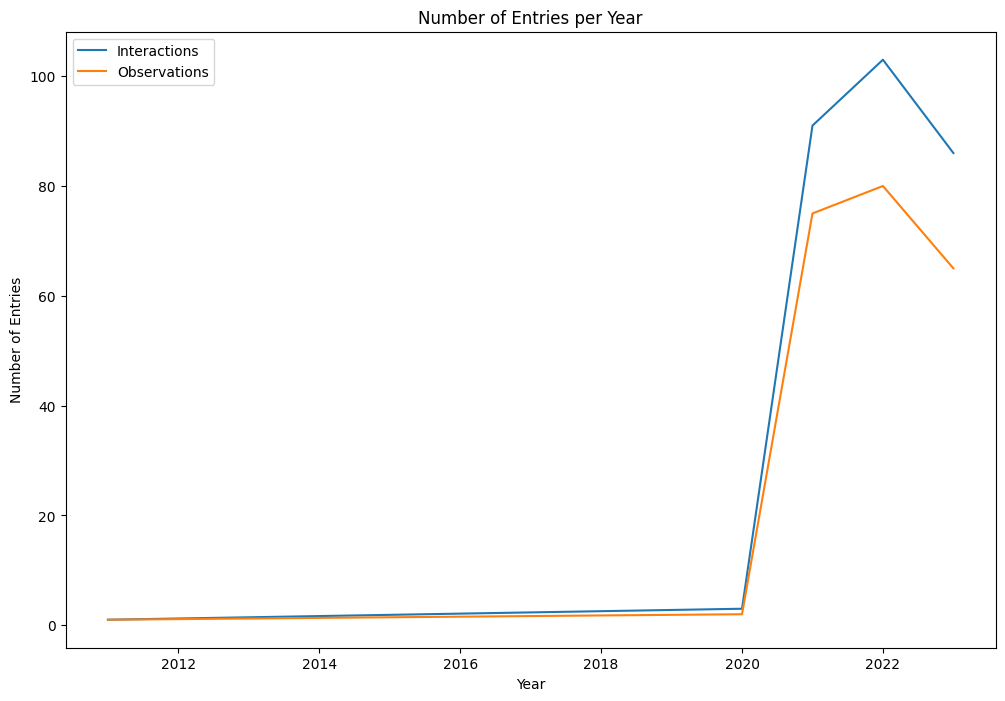

In [7]:
# amount of rows per year

num_inter = interactions_df.groupby('Date').size().groupby(lambda x: x.year).sum()
num_obsv = observations_df.groupby('Date').size().groupby(lambda x: x.year).sum()

# graph this out
plt.figure(figsize=(12, 8))
plt.plot(num_inter, label='Interactions')
plt.plot(num_obsv, label='Observations')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Year')
plt.legend()
plt.show()

In [8]:
# return 20 most frequent words, not including stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.extend(string.punctuation)
eng_stopwords.extend(['lower'])

def word_stats(data, stopwords=eng_stopwords, n=20):
    if (stopwords != None):
        for stopword in stopwords:
            del data[stopword]

    print("Number of total tokens in text:", sum(data.values()))
    print("Number of unique words in interactions:", len(data.values()))
    print("Top", n, "most frequent words in text:")
    print(data.most_common(n))

words = []
for description in interactions_df['Description of Interactions']:
    words += nltk.word_tokenize(description)
inter_counter = Counter(words)

words = []
for description in observations_df['Description of notable events']:
    words += nltk.word_tokenize(description)
obsv_counter = Counter(words)

print(word_stats(inter_counter))
print(word_stats(obsv_counter))


Number of total tokens in text: 2808
Number of unique words in interactions: 823
Top 20 most frequent words in text:
[('people', 103), ('casc', 103), ('trail', 63), ('2', 57), ('violations', 53), ('swimming', 45), ('I', 41), ('falls', 40), ('No', 37), ('one', 35), ('gorge', 35), ('asked', 33), ('leash', 33), ('today', 33), ('1', 27), ('dog', 27), ('bridge', 27), ('cascadilla', 27), ('water', 24), ('3', 23)]
None
Number of total tokens in text: 1834
Number of unique words in interactions: 923
Top 20 most frequent words in text:
[('I', 36), ('today', 28), ('people', 25), ('saw', 23), ('day', 23), ('casc', 20), ('trash', 19), ('Saw', 17), ('gorge', 17), ('notable', 14), ('trail', 13), ("n't", 13), ('got', 12), ('Beebe', 12), ('water', 12), ('nice', 12), ('lots', 11), ('many', 11), ('rain', 11), ('Nothing', 11)]
None


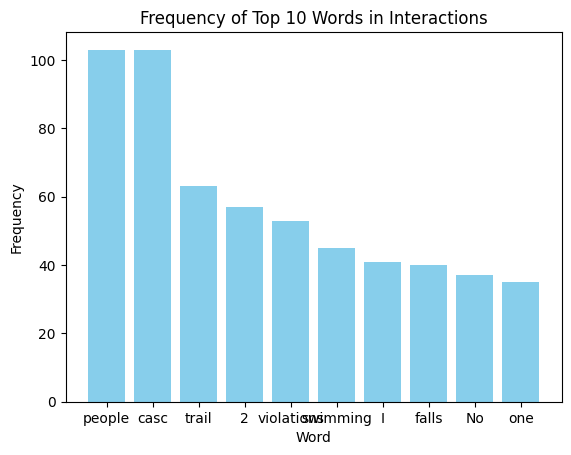

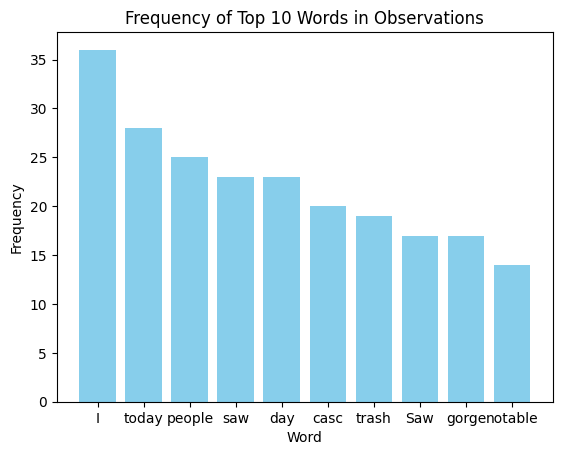

In [9]:
# visualization of the frequency of words in interactions

data = inter_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Interactions')
plt.show()

data = obsv_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Observations')
plt.show()

*Also at that cool stuff from the previous paper*


## Sentiment Analysis

#### Methods

In [10]:
# Score text sentiment
vader = SentimentIntensityAnalyzer()

# tokenizes text
def tokenize_text(text) :
    return [word_tokenize(sent.lower()) for sent in sent_tokenize(text)]

# method to return sentiment scores of a sentence
def text_sentiment(analyzer, tokens, vader_lexicon):
    sentiment_dict = analyzer.polarity_scores(' '.join(tokens))
    compound_score = sentiment_dict['compound']

    if compound_score >= 0.05:
        overall_sentiment = 'pos'
    elif compound_score <= -0.05:
        overall_sentiment = 'neg'
    else:
        overall_sentiment = 'neu'

    matched_terms = {}
    for token in tokens:
        token_lower = token.lower()
        if token_lower in vader_lexicon:
            matched_terms[token_lower] = vader_lexicon[token_lower]

    sentiment_dict['overall sentiment'] = overall_sentiment
    sentiment_dict['matched terms'] = matched_terms

    return sentiment_dict

def print_sentiment(sentiments_list):
  print("Total sentences:", len(sentiments_list))
  print("Total positive sentences:", sum([sent['overall sentiment'] == 'neg' for sent in sentiments_list]))
  print("Total neutral sentences:", sum([sent['overall sentiment'] == 'neu' for sent in sentiments_list]))
  print("Total negative sentences:", sum([sent['overall sentiment'] == 'pos' for sent in sentiments_list]))
  print("Average sentiment:", sum([sent['compound'] for sent in inter_sentiment]) / len(sentiments_list))

#### Interactions

In [11]:
# create a list of tokenized interactions
inter_tokens = []

for interaction in interactions:
  inter_tokens.extend(tokenize_text(interaction['msg']))

print(inter_tokens)
# we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# inter_tokens = [(filter(lambda x: x != "lower", sentence)) for sentence in inter_tokens]
# We also remove empty messages
# inter_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in inter_tokens]

inter_sentiment = [text_sentiment(vader, tokens, vader.lexicon) for tokens in inter_tokens]

print_sentiment(inter_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in inter_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

[['someone', 'asked', 'about', 'north', 'campus'], ['lots', 'of', 'commencement', 'direction', 'questions'], ['few', 'people', 'suntanning', 'on', 'rocks', 'in', 'the', 'water'], ['lots', 'of', 'people', 'looking', 'for', 'arboretum'], ['three', 'dogs', 'off', 'leash', 'on', 'bebee', 'lake', 'trail', 'and', 'cascadilla', 'trail'], ['2', 'people', 'past', 'trail', 'in', 'hemlock', 'gorge'], ['big', 'day', 'for', 'tourists'], ['small', 'day', 'for', 'violators'], ['1', 'dog', 'off', 'leash', 'on', 'upper', 'casc'], ['four', 'guys', 'taking', 'photos', 'in', 'lower', 'casc'], ['people', 'standing', 'in', 'the', 'water', 'near', 'falls'], ['people', 'on', 'other', 'side', 'of', 'fence'], ['people', 'sitting', 'in', 'water', 'near', 'falls'], ['not', 'many', 'people', 'put', 'and', 'about', 'today'], ['people', 'trying', 'to', 'swim', 'in', 'the', 'base', 'of', 'ithaca', 'falls', 'area'], ['child', 'leaning', 'over', 'the', 'edge', 'of', 'that', 'pool', 'part'], ['guy', 'fishing', 'at', 'en

#### Observations

In [12]:
# create a list of tokenized observations
obsv_tokens = []
for observation in observations:
  obsv_tokens.extend(tokenize_text(observation['msg']))

# # we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# obsv_tokens = [list(filter(lambda x: x != "lower", sentence)) for sentence in obsv_tokens]
# # We also remove empty messages
# obsv_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in obsv_tokens]

obsv_sentiment = [text_sentiment(vader, token, vader.lexicon) for token in obsv_tokens]

print_sentiment(obsv_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in obsv_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

Total sentences: 324
Total positive sentences: 40
Total neutral sentences: 211
Total negative sentences: 73
Average sentiment: -0.12713302469135776

Sentences with three or more matched terms:
neg
{'trouble': -1.7, 'violently': -2.8, 'threatened': -2.0}
---
pos
{'violations': -2.4, 'good': 1.9, 'nice': 1.8}
---
neg
{'surprised': 0.9, 'no': -1.2, 'violations': -2.4, 'number': 0.3, 'cool': 1.3}
---
pos
{'like': 1.5, 'great': 3.1, 'heron': 0.1}
---
pos
{'freaked': -1.2, 'hope': 1.9, 'okay': 0.9}
---
pos
{'nice': 1.8, 'great': 3.1, 'rainy': -0.3}
---
pos
{'love': 3.2, 'easily': 1.4, 'violators': -1.9}
---
pos
{'super': 2.9, 'rainy': -0.3, 'nice': 1.8, 'cool': 1.3}
---
pos
{'dead': -3.3, 'heroes': 2.3, 'save': 2.2}
---


#### Sentiment of Interactions Over The Years

In [13]:
inter_sent_date = []
for sent in interactions:
  token_sent = tokenize_text(sent['msg'])
  token_sent = (map(str, token_sent))
  token_sent = ' '.join(token_sent)

  sentiment = text_sentiment(vader, token_sent, vader.lexicon)
  content = {
      'date': sent['date'],
      'sentiment': sentiment
  }
  inter_sent_date.append(content)

inter_sent_date = pd.DataFrame(inter_sent_date)
inter_sent_date.date = pd.to_datetime(inter_sent_date.date).dt.year

# Calculate the average sentiment of interactions for each year
for key, group in inter_sent_date.groupby(inter_sent_date.date):
  print("Year", key)
  print_sentiment(group['sentiment'])
  print("---")

Year 2011.0
Total sentences: 9
Total positive sentences: 0
Total neutral sentences: 9
Total negative sentences: 0
Average sentiment: -4.5767888888888795
---
Year 2020.0
Total sentences: 14
Total positive sentences: 0
Total neutral sentences: 14
Total negative sentences: 0
Average sentiment: -2.9422214285714223
---
Year 2021.0
Total sentences: 477
Total positive sentences: 0
Total neutral sentences: 477
Total negative sentences: 0
Average sentiment: -0.08635450733752602
---
Year 2022.0
Total sentences: 501
Total positive sentences: 0
Total neutral sentences: 501
Total negative sentences: 0
Average sentiment: -0.0822177644710577
---
Year 2023.0
Total sentences: 556
Total positive sentences: 0
Total neutral sentences: 556
Total negative sentences: 0
Average sentiment: -0.07408471223021568
---


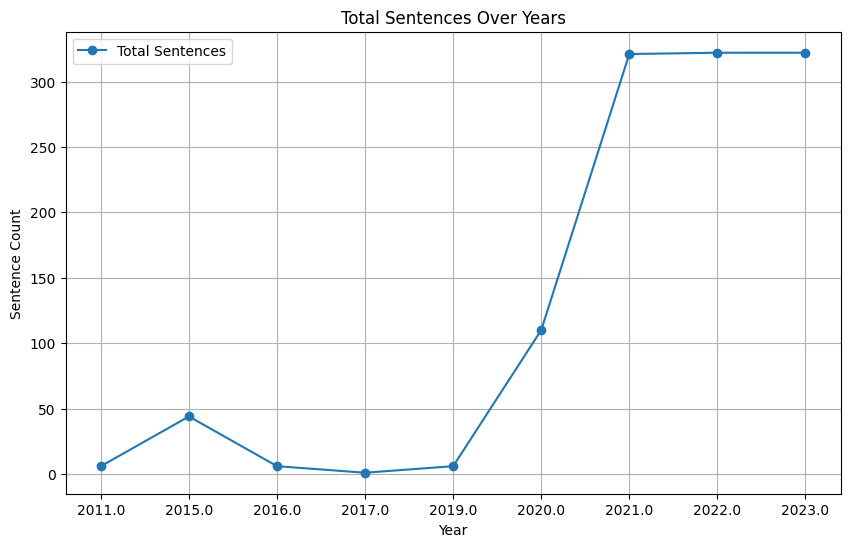

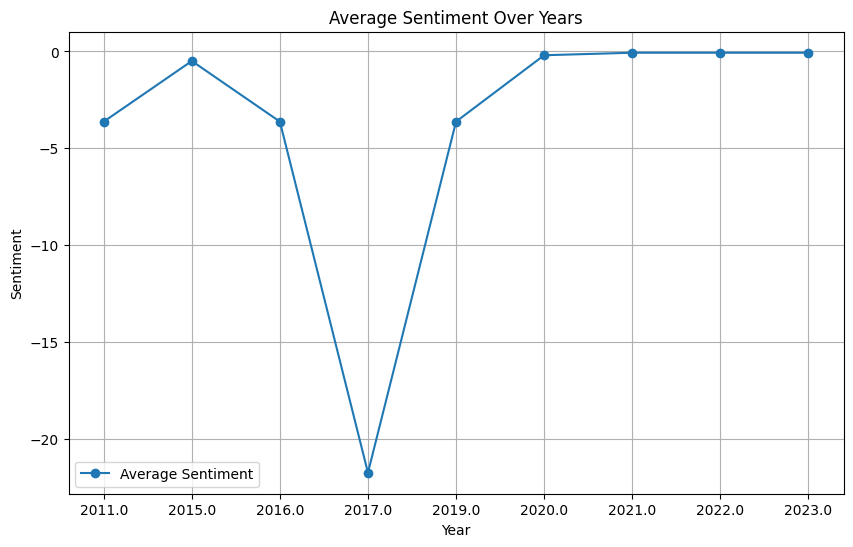

In [14]:
sent_year_output = """Year 2011.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2015.0 - Total sentences: 44 - Average sentiment: -0.49469545454545577
Year 2016.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2017.0 - Total sentences: 1 - Average sentiment: -21.766600000000054
Year 2019.0 - Total sentences: 6 - Average sentiment: -3.6277666666666755
Year 2020.0 - Total sentences: 110 - Average sentiment: -0.1978781818181823
Year 2021.0 - Total sentences: 321 - Average sentiment: -0.0678087227414332
Year 2022.0 - Total sentences: 322 - Average sentiment: -0.0675981366459629
Year 2023.0 - Total sentences: 322 - Average sentiment: -0.0675981366459629"""




# Extracting data
years = re.findall(r'Year (\d+\.\d+)', sent_year_output)
total_sentences = list(map(int, re.findall(r'Total sentences: (\d+)', sent_year_output)))
average_sentiments = list(map(float, re.findall(r'Average sentiment: (-?\d+\.\d+)', sent_year_output)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, total_sentences, label='Total Sentences', marker='o')
plt.xlabel('Year')
plt.ylabel('Sentence Count')
plt.title('Total Sentences Over Years')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, average_sentiments, label='Average Sentiment', marker='o')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('Average Sentiment Over Years')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# obsv_sent_date = []

# for sent in observations:
#   token_sent = tokenize_text(sent['msg'])
#   token_sent = (map(str, token_sent))
#   token_sent = ' '.join(token_sent)

#   sentiment = text_sentiment(vader, token_sent, vader.lexicon)
#   content = {
#       'date': sent['date'],
#       'sentiment': sentiment
#   }
#   obsv_sent_date.append(content)

#   obsv_sent_date = pd.DataFrame(obsv_sent_date)
#   obsv_sent_date.date = pd.to_datetime(obsv_sent_date.date).dt.year

#   # Calculate the average sentiment of interactions for each year
#   for key, group in obsv_sent_date.groupby(obsv_sent_date.date):
#     print("Year", key)
#     print_sentiment(group['sentiment'])
#     print("---")




## Euclidean Differences

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', norm='l2', use_idf=False)

# extract out only the messages of log
inter_obsv_tokens = [inter_tokens, obsv_tokens]

# features = vectorizer.fit_transform(inter_obsv_tokens)
features = tfidf_vectorizer.fit_transform([str(x) for x in inter_obsv_tokens])


print('Matrix shape:', features.shape)
# print('Feature labels:', vectorizer.get_feature_names_out())
# print('Stopwords used:', vectorizer.stop_words_, '\n')
# print('First line vector:', features[0].toarray(), '\n')

# print('Unique words:', list(set(log[0].split())))

euclidean_dist = euclidean_distances(features)
cosine_dist = cosine_distances(features)

print("\nEuclidean Distances (Normalized, TF-IDF):")
print(euclidean_dist)
print("\nCosine Distances (Normalized, TF-IDF):")
print(cosine_dist)



Matrix shape: (2, 1157)

Euclidean Distances (Normalized, TF-IDF):
[[0.         0.76598045]
 [0.76598045 0.        ]]

Cosine Distances (Normalized, TF-IDF):
[[0.         0.29336303]
 [0.29336303 0.        ]]


Matrix Shape:

The TF-IDF matrix has a shape of (2, 1396), indicating that there are 2 documents and 1396 features (likely unique terms or words after processing the text data).
Euclidean Distances (Normalized, TF-IDF):

This matrix shows the normalized Euclidean distances between pairs of documents.
The values in the matrix represent how "far apart" the documents are in the multi-dimensional space of the TF-IDF features.
The diagonal elements are zero, as each document is identical to itself.
The off-diagonal elements indicate the normalized Euclidean distances between the two documents.
In this case, the Euclidean distance between the two documents is 0.52700126.
Cosine Distances (Normalized, TF-IDF):

This matrix displays the normalized cosine distances between pairs of documents.
The values in the matrix represent how dissimilar the documents are based on cosine similarity (1 - cosine similarity).
The diagonal elements are zero, as each document is perfectly similar to itself.
The off-diagonal elements indicate the normalized cosine distances between the two documents.
In this case, the cosine distance between the two documents is 0.13886516.
Interpretation:

A lower value in the Euclidean Distances matrix and a higher value in the Cosine Distances matrix suggest that the two documents are more similar.
The specific values themselves are relative, and their interpretation may depend on the range of values typically observed in your dataset.
The Euclidean distance is generally small, indicating proximity in the TF-IDF feature space.
The Cosine distance is also small, suggesting high similarity between the two documents.
In summary, these results indicate that the two documents are close in both Euclidean and cosine distances, signifying a high degree of similarity based on their TF-IDF representations.

In [17]:
steward_log = inter_tokens
stweard_log = steward_log.extend(obsv_tokens)

print(len(steward_log))

print(steward_log[1])


1921
['lots', 'of', 'commencement', 'direction', 'questions']


## Unsupervised Clustering Labelling Types of Interactions




In [18]:
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=2)
        X_reduced = svd.fit_transform(X)
    else:
        X_reduced = X

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=alpha)
    ax1.set_title('Unclustered Data')

    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=alpha)
    ax2.set_title('Clustered Data')

    fig.suptitle(title)

    plt.show()

    # Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    unique_labels = np.unique(labels)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]

        print("Label:", label)
        print("Number of texts in this cluster:", len(label_indices))

        if len(label_indices) == 0:
            print("No texts in this cluster.")
        else:
            sampled_indices = np.random.choice(label_indices, size=min(n, len(label_indices)), replace=False)

            for i, index in enumerate(sampled_indices):
                print('\033[1m' + "Sample text", i + 1, "(Index:", index, "):" + '\033[0m', texts[index])

        print("----------------------------")

### Interactions

#### K-Means

Shape of clustered interactions: (285,)


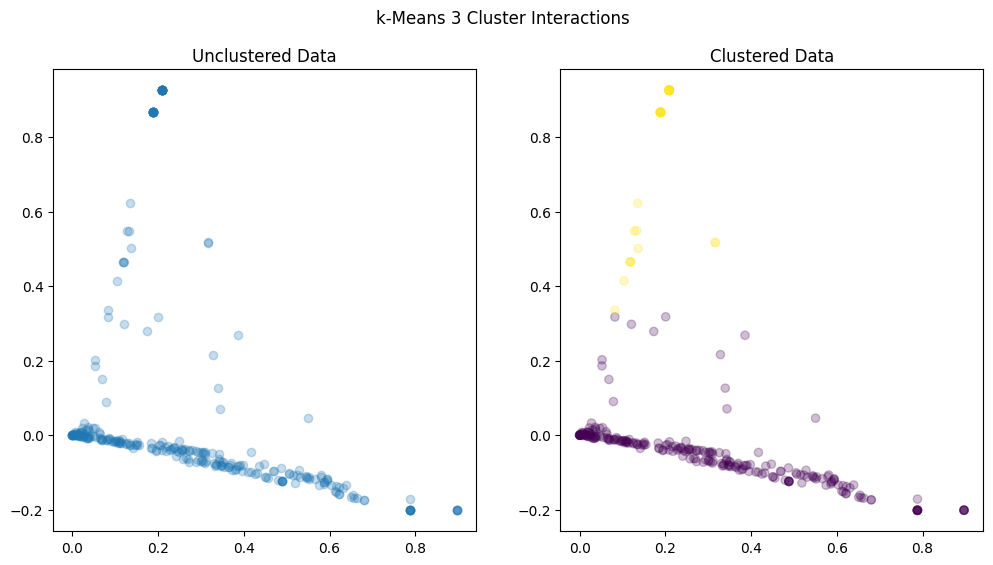

Label: 0
Number of texts in this cluster: 240
Sample text 1 (Index: 3 ): Lots of people looking for arboretum, three dogs off leash on Bebee Lake trail and Cascadilla Trail. 2 people past trail in Hemlock Gorge
Sample text 2 (Index: 154 ): all people off trail in casc :)
Sample text 3 (Index: 61 ): everyone loves that rock in casc
Sample text 4 (Index: 221 ): Talked to some women with dogs in the gorge behind Risley; lots of studentsswiming in hemlock gorge area; family of 4 trying to hop over fence to get to lower cascadilla
Sample text 5 (Index: 204 ): 2 people below suspension bridge above horseshoe falls, 3 people on Cascadilla Gorge trail closed section
Sample text 6 (Index: 201 ): 2 people above ithaca falls, 4 under the suspension bridge on fall creek
Sample text 7 (Index: 40 ): Four people off trail is cascadilla, two at the bottom, 2 at the top
Sample text 8 (Index: 2 ): few people suntanning on rocks in the water
Sample text 9 (Index: 33 ): person taking pick below suspension

In [19]:
# k-Means clustering with n_clusters = 2
inter = []
for interaction in interactions_unsplit:
  inter.append(interaction['msg'])

inter_tokens = tfidf_vectorizer.fit_transform(inter)


inter_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(inter_tokens)
print("Shape of clustered interactions:", inter_pred_2.shape)
plot_compare(inter_tokens, inter_pred_2, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_2, 10)

Cluster 1: No violations
Cluster 2: Yes Violations

Shape of clustered interactions: (285,)


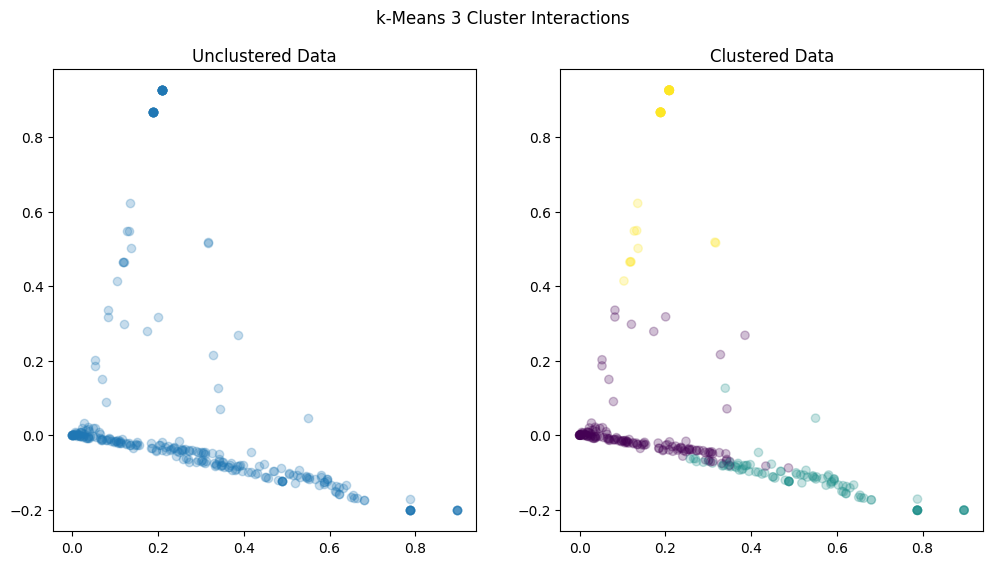

Label: 0
Number of texts in this cluster: 145
Sample text 1 (Index: 90 ): 2 people with a tripod taking photos in the water at cascadilla under big waterfall, one guy playing ukulele on the rocks of upper casc by the water
Sample text 2 (Index: 242 ): Helped a family locate the engineering quad
Sample text 3 (Index: 2 ): few people suntanning on rocks in the water
Sample text 4 (Index: 115 ): got to see my parents for a little bit at lunch! No problems today at ithaca falls
Sample text 5 (Index: 78 ): directions to campus
Sample text 6 (Index: 64 ): Two individuals were beyond the fence in Upper Cascadilla. I reminded them of the rules but they insisted they "had been doing this for 30 years and knew more than me." Which is fair but also I'm just doing my job?
Talked to a lovely couple briefly, too.
Sample text 7 (Index: 264 ): A dad and small kid swimming in the bottom falls at Cascadilla, left after speaking to them
Sample text 8 (Index: 112 ): many prospective students and visitors;

In [20]:
# k-Means clustering with n_clusters = 3
inter = []
for interaction in interactions_unsplit:
  inter.append(interaction['msg'])

inter_vectors = tfidf_vectorizer.fit_transform(inter)


inter_pred_3 = KMeans(n_clusters=3, n_init='auto', random_state=123).fit_predict(inter_vectors)
print("Shape of clustered interactions:", inter_pred_3.shape)
plot_compare(inter_tokens, inter_pred_3, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_3, 15)

Cluster 1: Violation
Cluster 2: No violation
CLuster 3: Cascidilla-related violation


#### Spectral Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering Labels Shape: (285,)


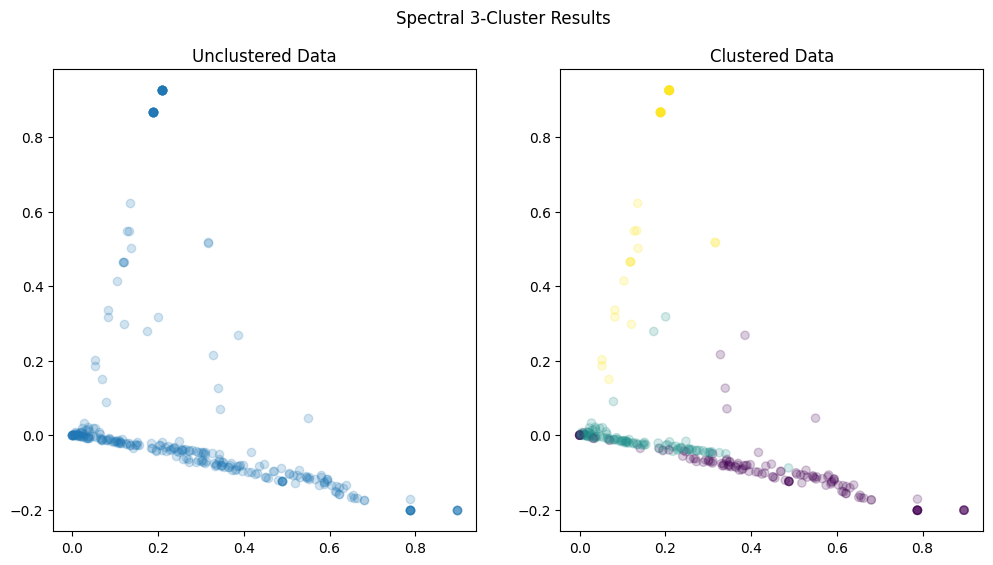

Label: 0
Number of texts in this cluster: 128
Sample text 1 (Index: 14 ): mentally disabled woman did not want to leave spot in casc, took two trys, lady with dog left when asked also in casc
Sample text 2 (Index: 130 ): one guy in the water at fall creek gorge, 5 people below stewart ave bridge near ezras tunnel who scurried away when I yelled and whistled (seemed like younger high schoolers to me), 3 off trail at casc, 2 off trail at casc
Sample text 3 (Index: 185 ): 1 dog off leash and 4 people wandering off trail
Sample text 4 (Index: 156 ): off trail in casc
Sample text 5 (Index: 95 ): none
Sample text 6 (Index: 101 ): all people going off trail in casc gorge. Momma duck down to 7 ducklings :(
Sample text 7 (Index: 71 ): none
Sample text 8 (Index: 88 ): 5 people in swimming hole upstream of tennis courts, 2 people swimming in cascadilla, 5 people wading in the water and drinking at casc right after the thunderstorm, 2 people sitting in casc past the fence,
Sample text 9 (Index: 18

In [21]:
spectral_clustering_3 = SpectralClustering(n_clusters=3, affinity='precomputed')

cosine_similarity_matrix = cosine_similarity(inter_vectors)

inter_spectral_3 = spectral_clustering_3.fit_predict(cosine_similarity_matrix)

print("Spectral Clustering Labels Shape:", inter_spectral_3.shape)

plot_compare(inter_vectors, inter_spectral_3, "Spectral 3-Cluster Results")

pull_samples(inter, inter_spectral_3, n=10)

Cluster 1: containing "all"
Cluster 2: Misc
Cluster 3: in casc
Cluster 4: no violations
Cluster 5: misc

#### DBSCAN

HDBSCAN Clustering Labels Shape: (285,)


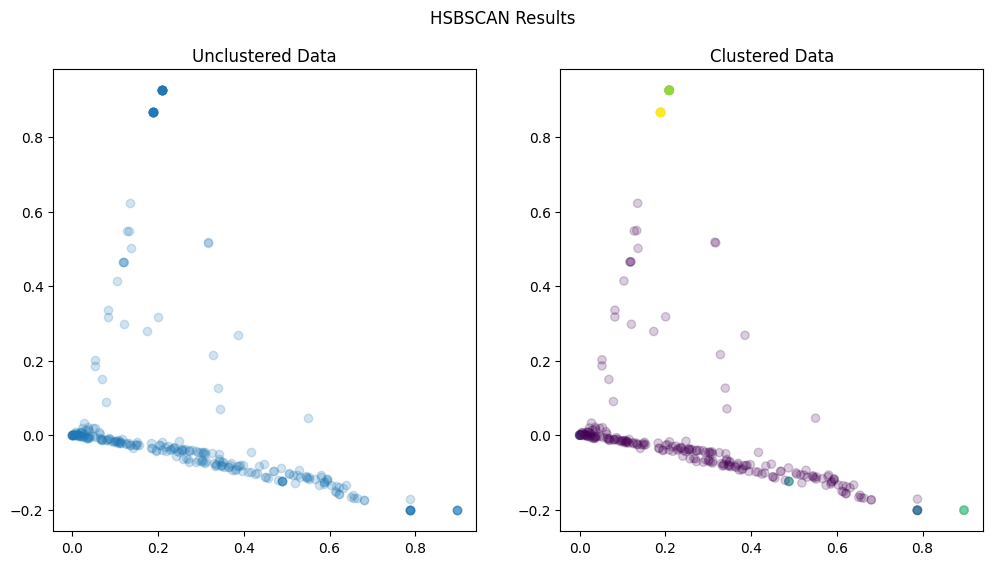

Label: -1
Number of texts in this cluster: 226
Sample text 1 (Index: 82 ): Directions near bebe again
Sample text 2 (Index: 99 ): 9 wading or dog off leash in casc, 2 in process of hopping fence in fall creek picnic area as I went by. All complied amicably. Snake swimming upriver in casc
Sample text 3 (Index: 210 ): Family of five past the signs in upper Hemlock Gorge
Sample text 4 (Index: 65 ): gave someone directions in between suspension and stewart
Sample text 5 (Index: 147 ): 2 people with off leash dog under bridge by tenis court, rest off trail in casc
----------------------------
Label: 0
Number of texts in this cluster: 7
Sample text 1 (Index: 155 ): none
Sample text 2 (Index: 96 ): none
Sample text 3 (Index: 93 ): none
Sample text 4 (Index: 71 ): none
Sample text 5 (Index: 95 ): none
----------------------------
Label: 1
Number of texts in this cluster: 8
Sample text 1 (Index: 142 ): off trail in casc
Sample text 2 (Index: 150 ): all off trail in casc
Sample text 3 (Index: 13

In [22]:
inter_hdv_pred = DBSCAN().fit_predict(inter_vectors.toarray())

print("HDBSCAN Clustering Labels Shape:", inter_hdv_pred.shape)

plot_compare(inter_vectors, inter_hdv_pred, "HSBSCAN Results")

pull_samples(inter, inter_hdv_pred, n=5)


### Violations

#### Create Violations Label

In [23]:
# add the cluster number as a dict key pair in interactions
for i, cluster in enumerate(inter_pred_3):
  if cluster == 1:
    interactions_unsplit[i]['violation_label'] = False
  else:
    interactions_unsplit[i]['violation_label'] = True
  if cluster == 2:
    interactions_unsplit[i]['casc_label'] = True
  else:
    interactions_unsplit[i]['casc_label'] = False

violation_count = 0
print("Violations sample:")
for interaction in interactions_unsplit:
  if interaction['violation_label'] == True:
    violation_count += 1
    if violation_count <= 5:
      print(interaction['msg'])

print('---')
no_vio_count = 0
print("No violations sample:")
for interaction in interactions_unsplit:
  if interaction['violation_label'] == False:
    no_vio_count += 1
    if no_vio_count <= 5:
     print(interaction['msg'])

print('---')
casc_count = 0
print("Casc sample:")
for interaction in interactions_unsplit:
  if interaction['casc_label'] == True:
    casc_count += 1
    if casc_count <= 5:
      print(interaction['msg'])

print('---')
print("Number of violations:", violation_count)
print("Number of no violations:", no_vio_count)
print("Number of casc violations:", casc_count)


Violations sample:
Someone asked about north campus
lots of commencement direction questions
few people suntanning on rocks in the water
Big day for tourists, small day for violators
People standing in the water near falls, people on other side of fence, people sitting in water near falls
---
No violations sample:
Lots of people looking for arboretum, three dogs off leash on Bebee Lake trail and Cascadilla Trail. 2 people past trail in Hemlock Gorge
1 dog off leash on upper casc
Four guys taking photos in lower Casc
mentally disabled woman did not want to leave spot in casc, took two trys, lady with dog left when asked also in casc
2 swimmers above beebe, 2 people picnicking in casc amphitheater area, various picture takers
---
Casc sample:
No violations today.
No violations today.
No violations today.
No violations today.
No violations today.
---
Number of violations: 189
Number of no violations: 96
Number of casc violations: 44


#### K-Means

189
Shape of clustered interactions: (189,)


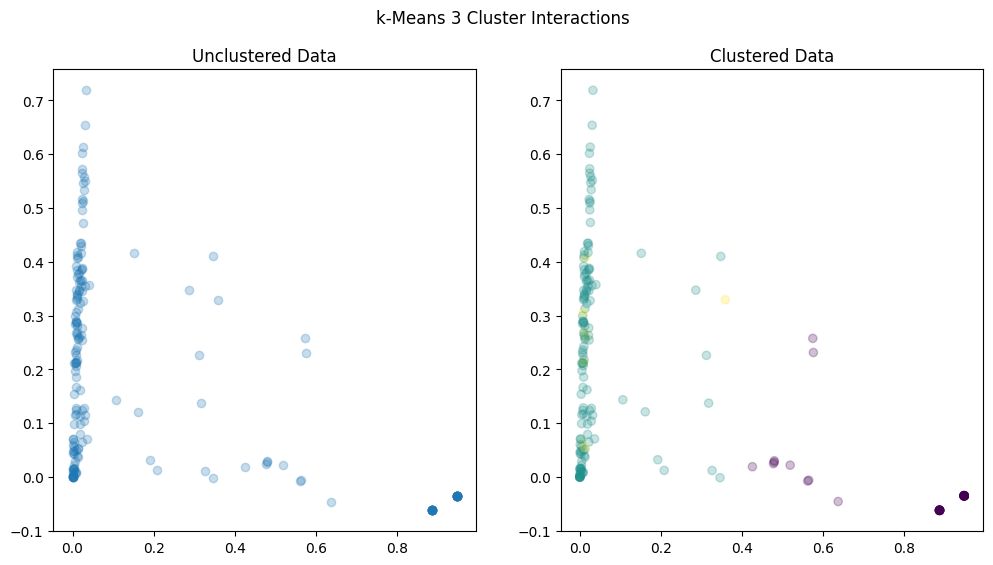

Label: 0
Number of texts in this cluster: 44
Sample text 1 (Index: 180 ): no violations
Sample text 2 (Index: 183 ): no violations
Sample text 3 (Index: 124 ): No violations today.
Sample text 4 (Index: 145 ): No violations.
Sample text 5 (Index: 172 ): No violations
Sample text 6 (Index: 171 ): No violations spotted
Sample text 7 (Index: 127 ): No violations today.
Sample text 8 (Index: 143 ): No violations today.
Sample text 9 (Index: 121 ): No violations today.
Sample text 10 (Index: 162 ): no violations. Helped a few families with directions
----------------------------
Label: 1
Number of texts in this cluster: 137
Sample text 1 (Index: 86 ): none
Sample text 2 (Index: 6 ): People trying to swim in the base of ithaca falls area, child leaning over the edge of that pool part, guy fishing at end of hemlock from atop waterfall. Lots of tourists and families. Lot of people who wanted to swim in weird places.
Sample text 3 (Index: 12 ): People cliff jumping in Hemlock gorge, asked them 

In [25]:
violations = []

for interaction in interactions_unsplit:
  if interaction['violation_label'] == True:
    violations.append(interaction)

print(len(violations))

vio = []
for violation in violations:
  vio.append(violation['msg'])

vio_tokens = tfidf_vectorizer.fit_transform(vio)

# k-means 3 cluster
vio_pred_3 = KMeans(n_clusters=3, n_init='auto').fit_predict(vio_tokens)
print("Shape of clustered interactions:", vio_pred_3.shape)
plot_compare(vio_tokens, vio_pred_3, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(vio, vio_pred_3, 10)

DBSCAN

DBSCAN Clustering Labels Shape: (189,)


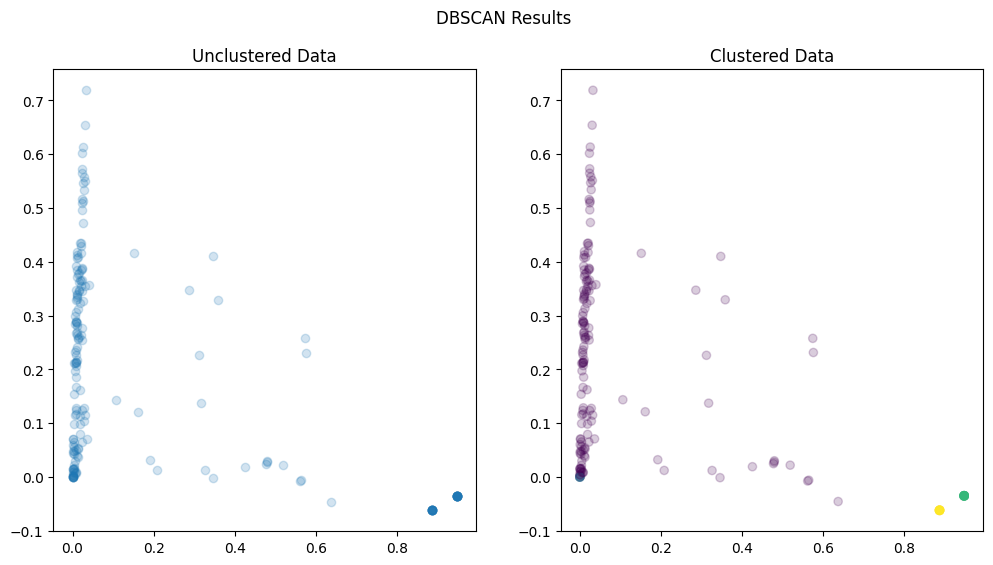

Label: -1
Number of texts in this cluster: 148
Sample text 1 (Index: 56 ): asked family to not wade in cascadilla, they said ok and left
Sample text 2 (Index: 72 ): got to see my parents for a little bit at lunch! No problems today at ithaca falls
Sample text 3 (Index: 21 ): 1 man trying to climb around the barrier on lower Cascadilla, asked him to turn around; group of 4 children under the bridge on upper Cascadilla, talked with kids and guardians
Sample text 4 (Index: 45 ): 1 guy fishing on top of falls by Beebe lake, said he wasn't from the area and didn't know. 2 Saw 2 girls on top of falls in Casc, attempting to walk down the side, blew whistle and gestured them out. They were gone by the time I got to the top of the stairs
Sample text 5 (Index: 47 ): lots of people asking for directions
----------------------------
Label: 0
Number of texts in this cluster: 7
Sample text 1 (Index: 44 ): none
Sample text 2 (Index: 16 ): none
Sample text 3 (Index: 63 ): none
Sample text 4 (Index: 61

In [27]:
vio_tokens = tfidf_vectorizer.fit_transform(vio)

vio_hdv_pred = DBSCAN().fit_predict(vio_tokens.toarray())

print("DBSCAN Clustering Labels Shape:", vio_hdv_pred.shape)

plot_compare(vio_tokens, vio_hdv_pred, "DBSCAN Results")

pull_samples(vio, vio_hdv_pred, n=5)

### Observations

#### K-Means

Shape of clustered interactions: (223,)


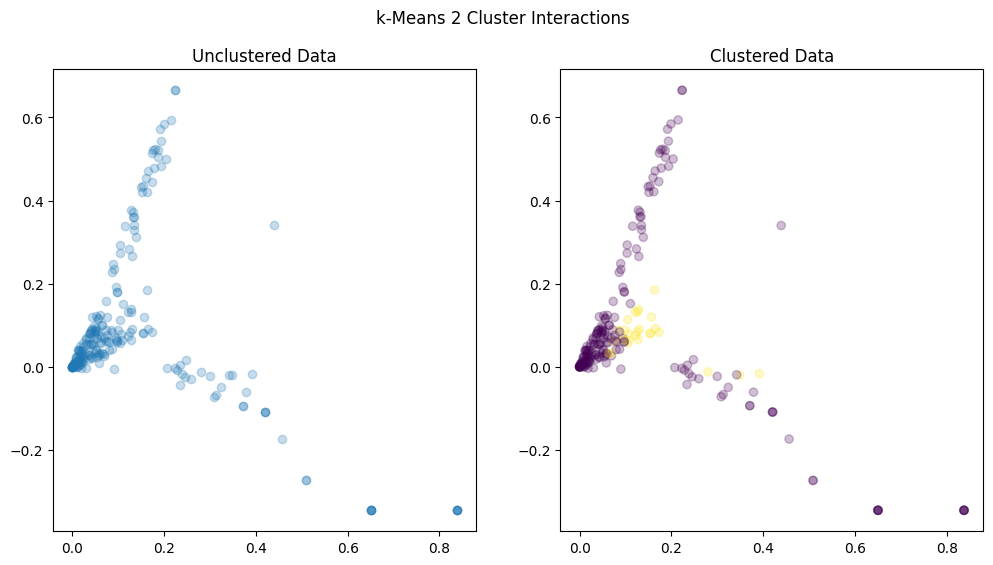

Label: 0
Number of texts in this cluster: 197
Sample text 1 (Index: 32 ): water was super high after the rain yesterday!
Sample text 2 (Index: 126 ): Some kind of incident at a home near ithaca falls, tons of firefighter. Almost freaked out but it wasn't related to the gorge, hope everyone is okay
Sample text 3 (Index: 31 ): The bike up E Buffalo is pretty steep!
Sample text 4 (Index: 191 ): Left for lunch as the heavy thunderstorms rolled in, ended up heading for home since the rain continued through the rest of the shift
Sample text 5 (Index: 106 ): got rained on. Am damp
----------------------------
Label: 1
Number of texts in this cluster: 26
Sample text 1 (Index: 188 ): Very slow and quiet day, the water was really high so there wasn't much space for people to get down into the gorge. 
Sample text 2 (Index: 214 ): Lots of people for Cornell Move in!!
Sample text 3 (Index: 143 ): I gave a couple people directions and took out a couple bits of trash
Sample text 4 (Index: 47 ): Many 

In [28]:
# k-Means clustering with n_clusters = 2
obsv = []
for observation in observations:
  obsv.append(observation['msg'])

obsv_vectors = tfidf_vectorizer.fit_transform(obsv)

obsv_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(obsv_vectors)
print("Shape of clustered interactions:", obsv_pred_2.shape)
plot_compare(obsv_vectors, obsv_pred_2, "k-Means 2 Cluster Interactions", alpha = 0.25)

pull_samples(obsv, obsv_pred_2, 5)

#### DBSCAN

DBSCAN Clustering Labels Shape: (223,)


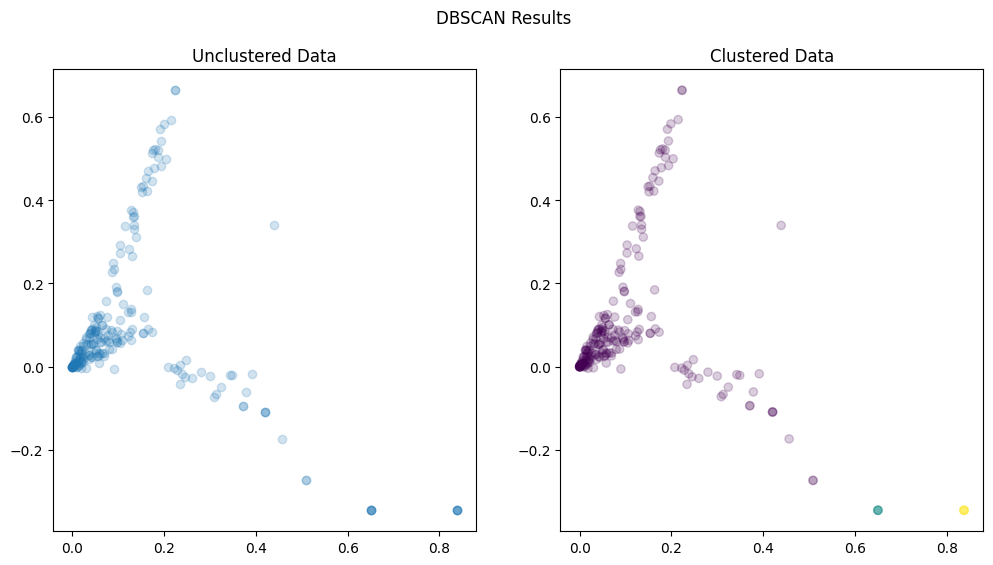

Label: -1
Number of texts in this cluster: 213
Sample text 1 (Index: 14 ): learned to ID poison ivy and virginia creeper; SAW A DEER UP CLOSE
Sample text 2 (Index: 83 ): five kids on rocks under stewart rd bridge that got there from ezra's tunnel; two swimmers in hemlock gorge
Sample text 3 (Index: 116 ): talked to one of the dads about the cornell gorges, gave directions to flat rock
Sample text 4 (Index: 122 ): got ice cream, saw snake
Sample text 5 (Index: 97 ): surprised there were no violations with the large number of people counted, maybe because of the cool temperatures or the fact that its tuesday
----------------------------
Label: 0
Number of texts in this cluster: 5
Sample text 1 (Index: 178 ): Nothing notable.
Sample text 2 (Index: 203 ): Nothing notable.
Sample text 3 (Index: 175 ): Nothing notable.
Sample text 4 (Index: 197 ): Nothing notable.
Sample text 5 (Index: 194 ): Nothing notable.
----------------------------
Label: 1
Number of texts in this cluster: 5
Sample tex

In [29]:
obsv_hdv_pred = DBSCAN().fit_predict(obsv_vectors.toarray())

print("DBSCAN Clustering Labels Shape:", obsv_hdv_pred.shape)

plot_compare(obsv_vectors, obsv_hdv_pred, "DBSCAN Results")

pull_samples(obsv, obsv_hdv_pred, n=5)

## Classification

#### Labelling

In [30]:
inter_tokenized = []
for inter in interactions_unsplit:
  inter_tokenized.append(nltk.word_tokenize(inter['msg']))

violation_labels = ['no violation', 'casc', 'other']

steward_labels = []
for interaction in interactions_unsplit:
  steward = interaction['steward']
  if steward not in steward_labels:
    steward_labels.append(steward)

year_labels = []
for interaction in interactions_unsplit:
  year = str(interaction['date']).split('-')[0]
  if year not in year_labels:
    year_labels.append(year)

In [31]:
false_positives = [0, 1, 4, 6, 8, 10, 11, 19, 22, 24, 27, 32, 39, 42, 49, 50, 57, 61, 62, 65, 69, 71, 78, 79, 81, 87, 93, 94, 95, 96, 104, 105, 107, 109, 115, 120, 144, 148, 155, 157, 171, 184, 198, 220, 226, 236, 242, 256, 299, 301,296, 295,294, 311, 314, 316, 317, 318, 319, 320, 322, 323, 324, 325, 326]
for interaction in interactions_unsplit:
  if interaction['index'] in false_positives:
    interaction['violation_label'] = False
    print(interaction['msg'])

Someone asked about north campus
lots of commencement direction questions
Big day for tourists, small day for violators
Four guys taking photos in lower Casc
not many people put and about today
1st interaction to give directions, 2nd interaction was to take a picture for a group
directions from suspension bridge
Didn't talk to anyone
none
N/A I don't think many people were out because it was supposed to rain
I helped an elderly couple find the easiest way out of the trail (they were worried about the incline) and informed someone about the partial closing of casc
took pictures for a family
elderly man told his wife to stay out of my way because I am staff
It started pouring by the time I got to casc, mostly people hurrying out at that point
gave someone directions to beebe lake
Everyone was happily minding their own cloudy day on the gorges today
no one looking to break rules or chat today
everyone loves that rock in casc
water was really flowing which inspired attempts to climb waterf

### Pre-Processing and Vectorizing

In [86]:
interactions_resplit = []
for interaction in interactions_unsplit:
    parts = re.split(r'[.,;\n]', interaction['msg'])
    for part in parts:
        part = part.strip()
        if part:
            new_inter = interaction.copy()
            new_inter['msg'] = part
            interactions_resplit.append(new_inter)

interactions_df = pd.DataFrame(interactions_resplit)

# for loop through interactions_df
for i, interaction in interactions_df.iterrows():
  interaction['index'] = i

interactions_df.set_index('index', inplace=True)
labels = interactions_df['violation_label']

print('Total interactions:',len(interactions_df))
print('number of violations:', len(interactions_df[interactions_df['violation_label'] == True]))
print('number of non-violations:', len(interactions_df[interactions_df['violation_label'] == False]))
print('interactions dataframe:')
interactions_df.head()


Total interactions: 591
number of violations: 308
number of non-violations: 283
interactions dataframe:


,date,steward,msg,violation_label,casc_label
index,,,,,
0,2023-05-25,Brenner,Someone asked about north campus,False,False
1,2023-05-26,Brenner,lots of commencement direction questions,False,False
2,2023-05-27,Brenner,few people suntanning on rocks in the water,True,False
3,2023-05-28,Phillip,Lots of people looking for arboretum,False,False
3,2023-05-28,Phillip,three dogs off leash on Bebee Lake trail and C...,False,False


In [246]:
# vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    use_idf=True)

inter_feats = tfidf_vectorizer.fit_transform(interactions_df['msg'])

print("Feature matrix shape:", inter_feats.shape)

tfidf_vectorizer.get_feature_names_out()[:25]

Feature matrix shape: (591, 801)


array(['10', '10yo', '11', '12', '15', '1999', '1st', '2nd', '30', '50',
       '80s', 'able', 'about', 'above', 'accumulating', 'across',
       'actually', 'adults', 'advised', 'after', 'afternoon', 'again',
       'air', 'all', 'allowed'], dtype=object)

### Model Evaluation

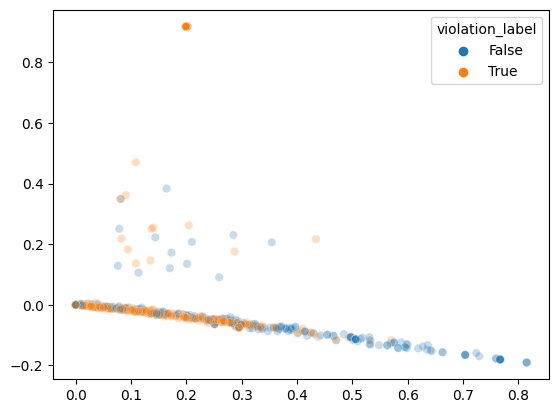

In [243]:
X_reduced = TruncatedSVD().fit_transform(inter_feats)
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=interactions_df['violation_label'], alpha=0.25)
plt.show()

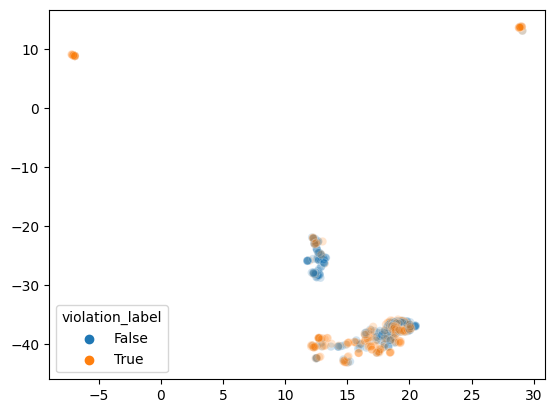

In [93]:
X_umap = UMAP().fit_transform(inter_feats)
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=interactions_df['violation_label'], alpha=0.2)
plt.show()

In [244]:
# Calculate baseline performance

most_common_label = labels.mode().iloc[0]

base_preds = [most_common_label] * len(labels)

base_acc = accuracy_score(labels, base_preds)
print("Baseline Accuracy:", base_acc)

base_f1_score = f1_score(labels, base_preds, average='binary', pos_label=most_common_label)
print("Baseline F1 Score:", base_f1_score)


Baseline Accuracy: 0.5211505922165821
Baseline F1 Score: 0.6852057842046719


In [113]:
# select kbest features
%%capture

from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_best = SelectKBest(score_func=mutual_info_classif, k=8)
selected_features = k_best.fit_transform(inter_feats, labels)
selected_feature_indices = k_best.get_support(indices=True)
selected_feature_names = tfidf_vectorizer.get_feature_names_out()[selected_feature_indices]

In [114]:
print(selected_feature_names)

['casc' 'in' 'no' 'off' 'the' 'to' 'trail' 'violations']


In [254]:
# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'rand_forest': RandomForestClassifier(),
    'naive_bayes': GaussianNB(),
    'multiNB': MultinomialNB(),
    'svc': SVC()
}

def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [255]:
scores_dict = {}

for clf_model, clf in classifiers.items():
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_micro']
        scores = cross_validate(clf, inter_feats.toarray(), labels, cv=5, scoring=scoring)
        scores_dict[clf_model] = {
            'Accuracy': np.mean(scores['test_accuracy']),
            'Precision (Macro)': np.mean(scores['test_precision_macro']),
            'Recall (Macro)': np.mean(scores['test_recall_macro']),
            'F1 (Macro)': np.mean(scores['test_f1_macro']),
            'F1 (Micro)': np.mean(scores['test_f1_micro'])
        }

scores_df = compare_scores(scores_dict)
display(scores_df)

,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),F1 (Micro)
kNN,0.597479,0.639406,0.592042,0.534327,0.597479
Logit,0.698832,0.706865,0.694028,0.691348,0.698832
decision_tree,0.663353,0.666115,0.662414,0.660174,0.663353
rand_forest,0.666771,0.672330,0.665268,0.660701,0.666771
naive_bayes,0.531406,0.539154,0.537986,0.517325,0.531406
multiNB,0.695442,0.700306,0.691954,0.690149,0.695442
svc,0.685429,0.700721,0.678355,0.670179,0.685429


In [248]:
max_depth_values = [None, 100000, 1000, 100, 20, 10, 5]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = {}

def get_accuracy_scores(max_depth):
    classifier = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_validate(classifier, inter_feats.toarray(), labels, cv=cv, scoring='accuracy')
    return np.mean(scores['test_score'])

for depth in max_depth_values:
    accuracy_scores[depth] = get_accuracy_scores(depth)

for depth, accuracy in accuracy_scores.items():
    print(f"Max Depth: {depth if depth is not None else 'Unlimited'}: Accuracy: {accuracy:.4f}")


Max Depth: Unlimited: Accuracy: 0.6853
Max Depth: 100000: Accuracy: 0.7005
Max Depth: 1000: Accuracy: 0.6970
Max Depth: 100: Accuracy: 0.7073
Max Depth: 20: Accuracy: 0.6919
Max Depth: 10: Accuracy: 0.6666
Max Depth: 5: Accuracy: 0.7021


In [249]:
%%capture

naive_bayes_classifier = MultinomialNB()

f1_scores_naive_bayes = []

# we iterate over different feature counts (1-5) and find the best F1 score based on cross-validation
for k in range(1, 10):
    selected_features = selector.fit_transform(inter_feats, labels)

    f1_scores = cross_validate(naive_bayes_classifier, selected_features, labels, cv=5,
                               scoring=make_scorer(f1_score, average='weighted'))['test_score']

    f1_scores_naive_bayes.append((k, f1_scores.mean()))

best_k_naive_bayes, best_f1_naive_bayes = max(f1_scores_naive_bayes, key=lambda x: x[1])

print(f"Best Number of Features for Naive Bayes: {best_k_naive_bayes}")
print(f"Best F1 Score for Naive Bayes: {best_f1_naive_bayes:.4f}")


In [147]:
print(f"Best Number of Features for Naive Bayes: {best_k_naive_bayes}")
print(f"Best F1 Score for Naive Bayes: {best_f1_naive_bayes:.4f}")

Best Number of Features for Naive Bayes: 1
Best F1 Score for Naive Bayes: 0.6758


In [151]:
knn_classifier = KNeighborsClassifier()

f1_scores_knn = []

# Iterate over different k values and find the best k value
for k in range(1, 10):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(inter_feats.toarray())

    f1_scores = cross_validate(knn_classifier, scaled_data, labels, cv=5,
                               scoring=make_scorer(f1_score, average='weighted'))['test_score']

    f1_scores_knn.append((k, f1_scores.mean()))

best_k_knn, best_f1_knn = max(f1_scores_knn, key=lambda x: x[1])

print(f"Best Number of Neighbors (k) for kNN: {best_k_knn}")
print(f"Best F1 Score for kNN: {best_f1_knn:.4f}")

Best Number of Neighbors (k) for kNN: 1
Best F1 Score for kNN: 0.5765


## Topic Models

In [164]:
def display_topics(model, feature_names, k_top_words, title, n_topics=10):
    fig, axes = plt.subplots(round(n_topics/5), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-k_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [169]:
count_vectorizer = CountVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
    min_df = 0.001,
    max_df = 0.25
)

inter_count_feats = count_vectorizer.fit_transform(interactions_df['msg'])

### LDA

In [186]:
# topic model code
lda = LatentDirichletAllocation(
    n_components=20,
    n_jobs=-1,
    verbose=1,
    max_iter=10,
    evaluate_every=0
)

lda.fit(inter_count_feats)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

###

IndexError: ignored

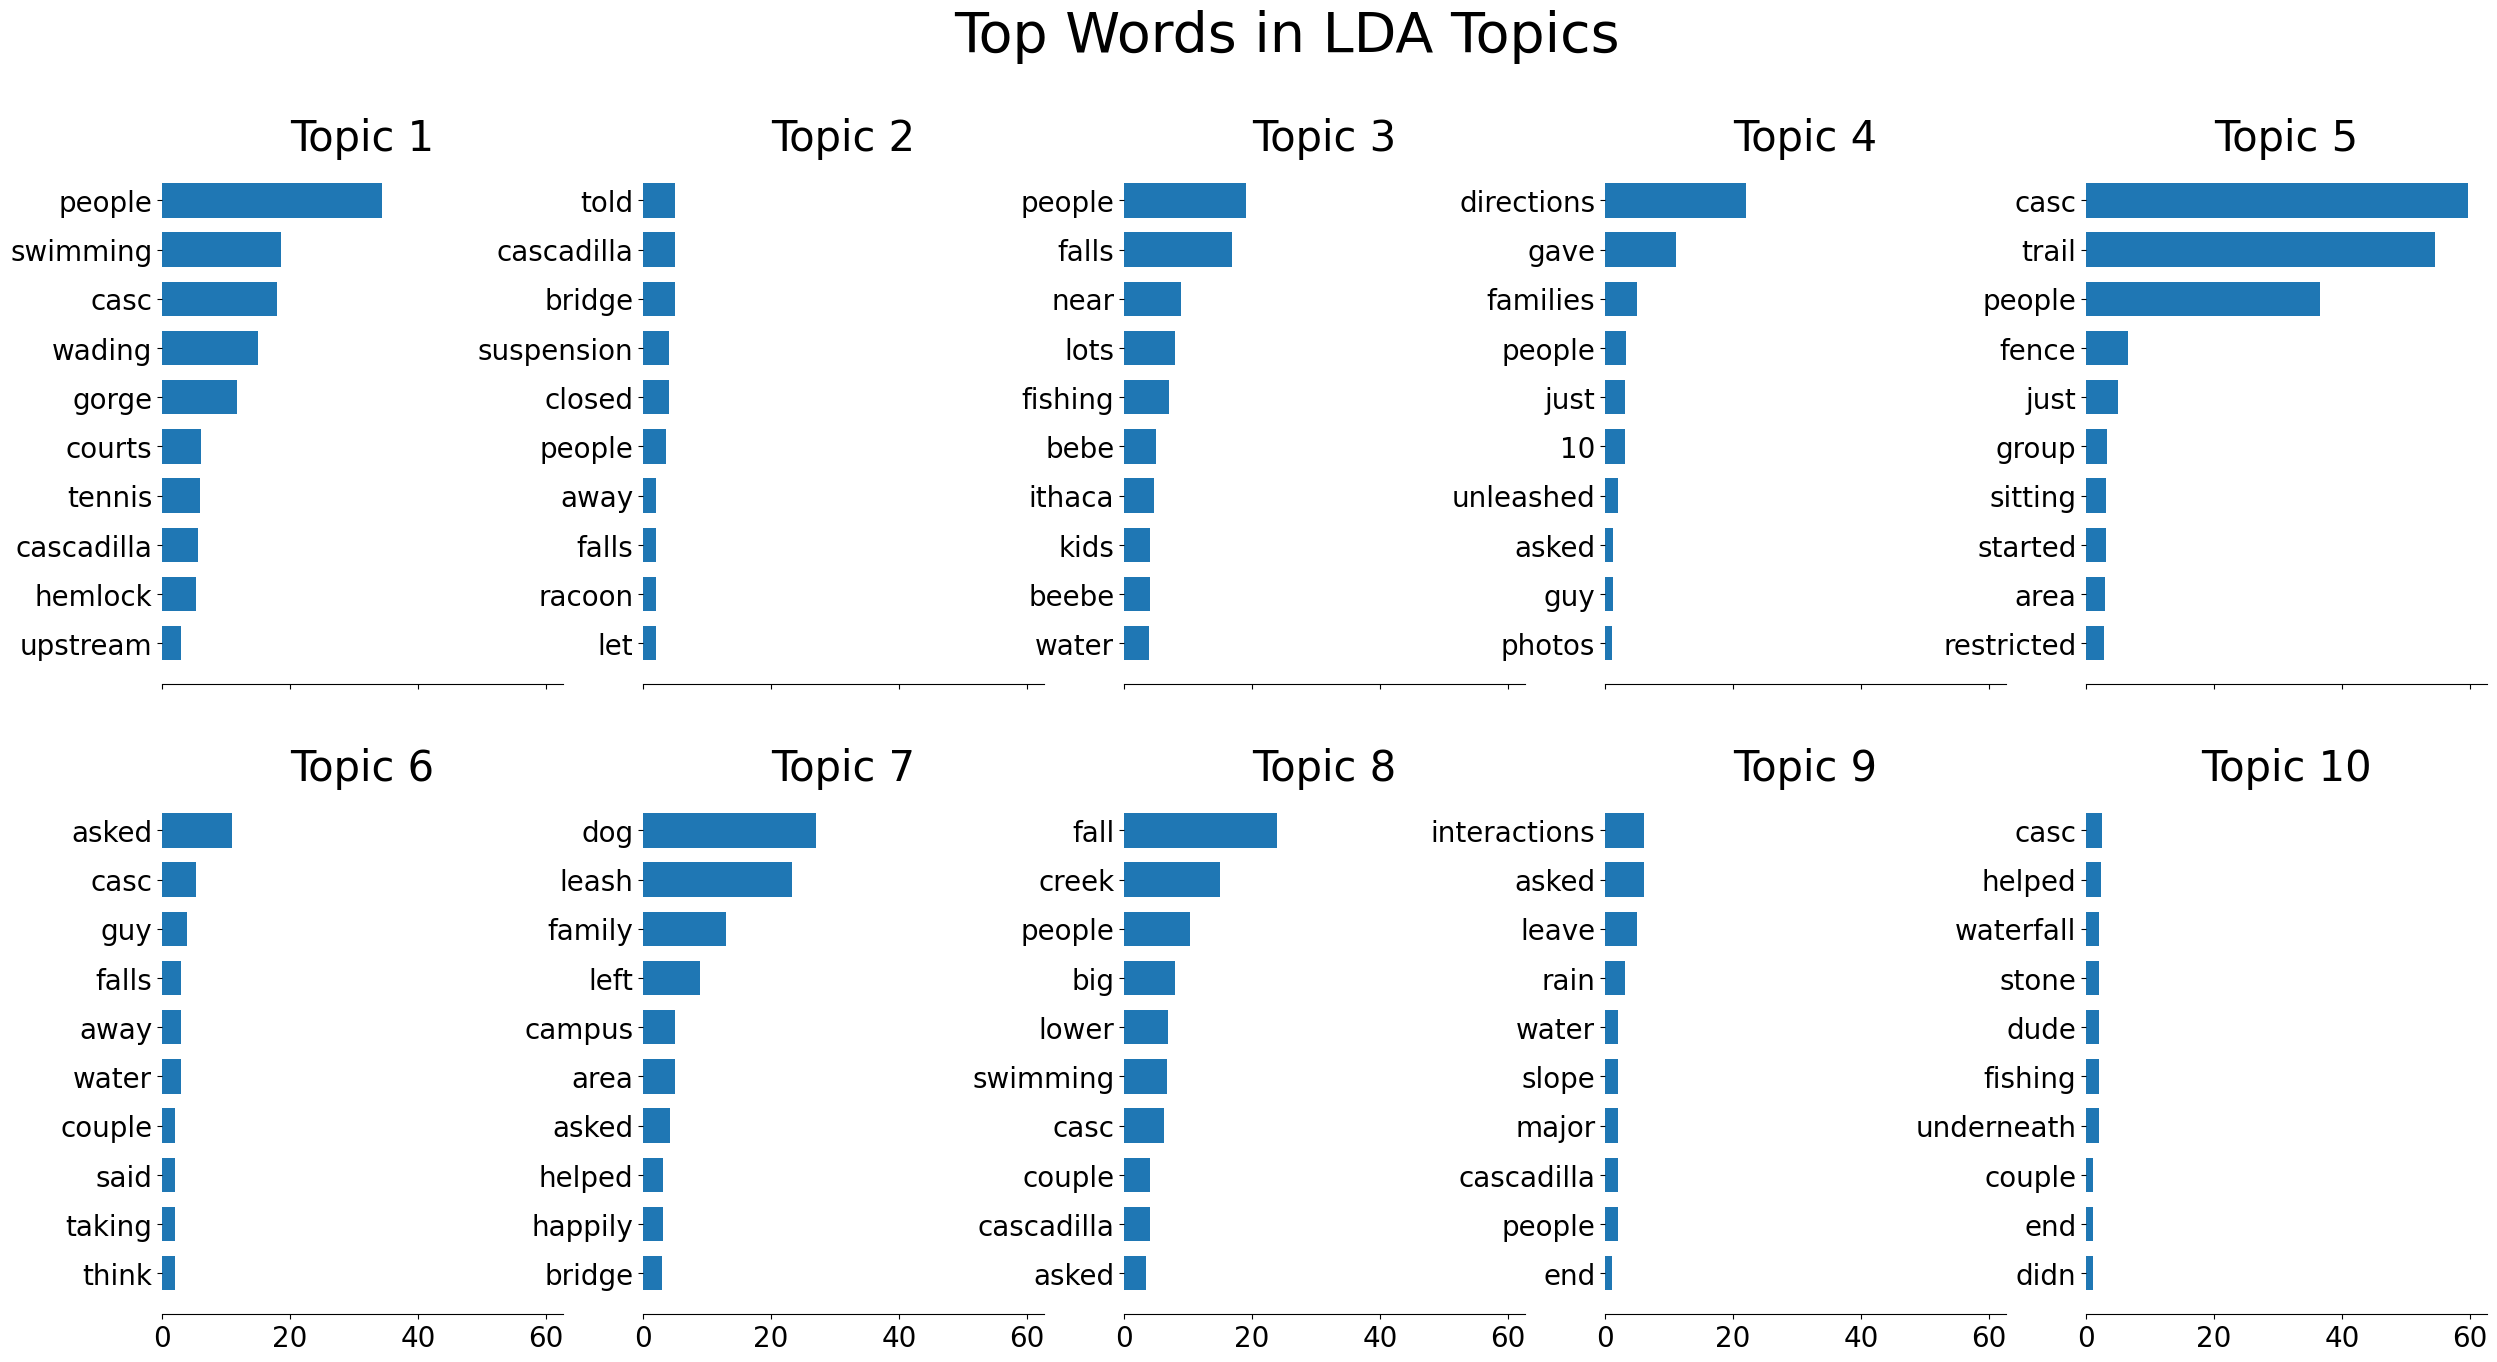

In [187]:
# plot topic output


k_top_words = 10
feature_names = count_vectorizer.get_feature_names_out()
title = "Top Words in LDA Topics"

display_topics(lda,
               feature_names,
               k_top_words,
               title)


In [190]:
# doc-topic matrix
doc_topic_matrix = lda.transform(inter_count_feats)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

X_topics = doc_topic_matrix
y = interactions_df['violation_label']

classifier = LogisticRegression(max_iter=1000)

cross_val_scores = cross_val_score(classifier,
                                   X_topics,
                                   y,
                                   cv=5,
                                   scoring='f1_weighted')

average_weighted_f1 = cross_val_scores.mean()

print("Average Cross-Validated Weighted F1 Score:", average_weighted_f1)

Doc-topic matrix shape: (591, 20)
Average Cross-Validated Weighted F1 Score: 0.5716218077542861


In [205]:
# classify using informative tokens
k_best = SelectKBest(score_func=mutual_info_classif, k=25)
x_best_features = k_best.fit_transform(inter_count_feats, interactions_df['violation_label'])

cross_val_scores = cross_val_score(classifier,
                                   x_best_features,
                                   interactions_df['violation_label'],
                                   cv=5,
                                   scoring='f1_weighted')

average_f1_score = cross_val_scores.mean()

print("Shape of the Input Matrix:", x_best_features.shape)
print("Average Cross-Validated Weighted F1 Score:", average_f1_score)

Shape of the Input Matrix: (591, 25)
Average Cross-Validated Weighted F1 Score: 0.720037427295394


In [206]:
# classify using SVD
svd = TruncatedSVD(n_components=20)

x_svd = svd.fit_transform(inter_count_feats)

classifier = LogisticRegression(max_iter=1000)

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

cross_val_scores = cross_val_score(classifier,
                                   x_svd,
                                   labels,
                                   cv=5,
                                   scoring=weighted_f1_scorer)

average_f1_score = cross_val_scores.mean()

print("Shape of the Input Matrix (TruncatedSVD):", x_svd.shape)
print("Average Cross-Validated Weighted F1 Score (TruncatedSVD):", average_f1_score)


Shape of the Input Matrix (TruncatedSVD): (591, 20)
Average Cross-Validated Weighted F1 Score (TruncatedSVD): 0.6894588069305858


## BERT-Based Classifer

### Train Test Split

In [332]:
inter_texts = {'violation': [], 'non-violation': []}

for index, interaction in interactions_df.iterrows():
  if interaction['violation_label'] == True:
    label = 'violation'
  else:
    label = 'non-violation'
  msg = interaction['msg']
  inter_texts[label].append(msg)

print("Total number of texts:", len(inter_texts['violation']) + len(inter_texts['non-violation']))
print("Number of violation texts:", len(inter_texts['violation']))
print("Number of non-violation texts:", len(inter_texts['non-violation']))

Total number of texts: 591
Number of violation texts: 308
Number of non-violation texts: 283


In [337]:
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for label, text in inter_texts.items():
  test_split = int(len(text) * 0.8)
  validation_split = int(test_split * 0.2)
  text = random.sample(text, len(text))

  for poem in text[test_split:]:
    test_texts.append(poem)
    test_labels.append(label)

  for poem in text[:test_split]:
    train_texts.append(poem)
    train_labels.append(label)

print("80/20 Train-test split:")
print("Training set:", len(train_texts), "texts and", len(train_labels), "labels")
print("Testing set:", len(test_texts), "texts and", len(test_labels), "labels")


80/20 Train-test split:
Training set: 472 texts and 472 labels
Testing set: 119 texts and 119 labels


In [338]:
# logistic regression

# Logistic Regrrssion
clf = LogisticRegression().fit(X_train, train_labels)
predictions = clf.predict(X_test)

# Printing classif report after applyig model
print(classification_report(test_labels, predictions, zero_division=0))

               precision    recall  f1-score   support

non-violation       0.39      0.39      0.39        57
    violation       0.44      0.45      0.45        62

     accuracy                           0.42       119
    macro avg       0.42      0.42      0.42       119
 weighted avg       0.42      0.42      0.42       119



In [339]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
tree_clf = DecisionTreeClassifier()
random_clf = RandomForestClassifier(n_estimators=100, random_state=42)

selector = SelectKBest(k=60)
X_train_selected = selector.fit_transform(X_train, train_labels)
X_test_selected = selector.transform(X_test)

# KNN Classifier
knn_clf.fit(X_train_selected, train_labels)
knn_preds = knn_clf.predict(X_test_selected)

print(":::::::::::::::::::::::::::::::::::\nMetrics of KNN Model")
print(classification_report(test_labels, knn_preds, zero_division=0))

# Decision Tree
tree_clf.fit(X_train, train_labels)
tree_preds = tree_clf.predict(X_test)

print(':::::::::::::::::::::::::::::::::::\nDecision Tree Metrics')
print(classification_report(test_labels, tree_preds, zero_division=0))

# Random Forest
random_clf.fit(X_train_selected, train_labels)
random_preds = random_clf.predict(X_test_selected)

print(':::::::::::::::::::::::::::::::::::\nRandom Forest Metrics')
print(classification_report(test_labels, random_preds, zero_division=0))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  2  14  23  27  34  43  49  54  55  58  73  77  91 102 104 114 115 117
 121 144 156 171 175 177 186 189 210 219 229 238 244 245 263 275 289 294
 329 330 333 340 354 363 365 377 386 398 400 420 434 441 450 455 460 471
 474 475 480 481 488 489 490 491 498 499 500 506 510 531 540 541 542 550
 562 565 585 592 595 603 605 607 620 634 645 646 649 650] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


:::::::::::::::::::::::::::::::::::
Metrics of KNN Model
               precision    recall  f1-score   support

non-violation       0.46      0.86      0.60        57
    violation       0.33      0.06      0.11        62

     accuracy                           0.45       119
    macro avg       0.40      0.46      0.35       119
 weighted avg       0.39      0.45      0.34       119

:::::::::::::::::::::::::::::::::::
Decision Tree Metrics
               precision    recall  f1-score   support

non-violation       0.43      0.35      0.39        57
    violation       0.49      0.58      0.53        62

     accuracy                           0.47       119
    macro avg       0.46      0.47      0.46       119
 weighted avg       0.47      0.47      0.46       119

:::::::::::::::::::::::::::::::::::
Random Forest Metrics
               precision    recall  f1-score   support

non-violation       0.44      0.68      0.54        57
    violation       0.42      0.21      0.28      

### Tokenizing

In [340]:
# encode and tokenize data for lil BERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [341]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

print(label2id.keys())

dict_keys(['violation', 'non-violation'])


In [343]:
# encode and tokenize data for lil BERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True)

' '.join(train_encodings[1].tokens[0:100])

'[CLS] Man in gorge ##s at top ##e of be ##be lake ( probably fishing but packed up really fast ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

### Mapping Labels

In [345]:
# set labels
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

print("label2id and id2label keys:")
print(label2id.keys())
print(id2label.keys())

label2id and id2label keys:
dict_keys(['violation', 'non-violation'])
dict_keys([0, 1])


### Encoding

In [347]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

type(train_encodings)

Poem in the training set after encoding:
[101, 2268, 1107, 25601, 1116, 1120, 1499, 1162, 1104, 1129, 3962, 3521, 113, 1930, 5339, 1133, 8733, 1146, 1541, 2698, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---
Poem in the test set after encoding:
[101, 1185, 7739, 114, 1115, 1175, 1108, 1126, 1586, 3068, 5183, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---
Train-test labels:
{0, 1}
{0, 1}


### Custom Torch Dataset

In [353]:
# mydataset class
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [354]:
# create datasets
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

print(f"train_dataset: {train_dataset}")
print(f"test_dataset: {test_dataset}")
print(f"train_dataset length: {len(train_dataset)}")
print(f"test_dataset length: {len(test_dataset)}")

train_dataset: <__main__.MyDataset object at 0x78e1ad3bffa0>
test_dataset: <__main__.MyDataset object at 0x78e1ad3be4a0>
train_dataset length: 472
test_dataset length: 119


### Model Training

In [356]:
# set gpus as runtime engine

device = 'cuda' # nvidia gpu
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
model.device

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

RuntimeError: ignored

In [355]:
model = DistilBertForSequenceClassification.from_pretrained(
  'distilbert-base-cased',
  num_labels=len(id2label)
).to('cuda')

NameError: ignored